# Assignment-2 Optimal Policies with Dynamic Programming

### Background
Gridworld City, a thriving metropolis with a booming technology industry, has recently experienced an influx of grid-loving software engineers. Unfortunately, the ***city's street parking system***, which ***charges a fixed rate, is struggling to keep up with the increased demand***. 

To address this, the city council has ***decided to modify the pricing scheme to better promote social welfare***. In general, the city considers ***social welfare higher when more parking is being used, the exception being that the city prefers that at least one spot is left unoccupied*** (so that it is available in case someone really needs it). 

The city council has created a ***Markov decision process (MDP) to model the demand for parking with a reward function that reflects its preferences***. Now the city has hired us &mdash; an expert in dynamic programming &mdash; to help determine an optimal policy.


### This assignment will help to understand:
- ***Policy Evaluation*** and ***Policy Improvement***
- ***Value and Policy Iteration***
- ***Bellman Equations***


### Table of Content
- 0. Preliminaries
- 1. Policy Evaluation
- 2. Policy Iteration
- 3. Value Iteration

# 0. Preliminaries
We'll need two imports to complete this assigment:
- numpy: The fundamental package for scientific computing with Python.
- tools: A module containing an environment and a plotting function.

In [1]:
%matplotlib inline
import numpy as np
import tools
import pickle

<Figure size 432x288 with 0 Axes>

In the City Council's Parking MDP:
- ***states :*** are nonnegative integers indicating how many parking spaces are occupied
- ***actions :*** are nonnegative integers designating the price of street parking
- ***reward :*** is a real value describing the city's preference for the situation
- ***time :*** is discretized by hour

As might be expected, charging a high price is likely to decrease occupancy over the hour, while charging a low price is likely to increase it.

### For now, let's consider an environment with ***3 parking spaces and 3 price points***. 

Note that an environment with ***three parking spaces actually has four states*** &mdash; zero, one, two, or three spaces could be occupied.

In [2]:
# Create Environment
num_spaces = 3                                            # 3 Parking spaces (0,1,2,3 = total 4 states)
num_prices = 3                                            # 3 Pricing points

env = tools.ParkingWorld(num_spaces, num_prices)          # setup Parking World environment 

V = np.zeros(num_spaces + 1)                              # One-dimensional array where the i-th entry gives the value of i spaces being occupied

pi = np.ones((num_spaces + 1, num_prices)) / num_prices   # policy pi: two-dimensional array where the (i, j)-th entry
                                                            # gives the probability of taking action j in state i

print('Value Function:', V)
print('')
print('Policy pi:', pi)

Value Function: [0. 0. 0. 0.]

Policy pi: [[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]


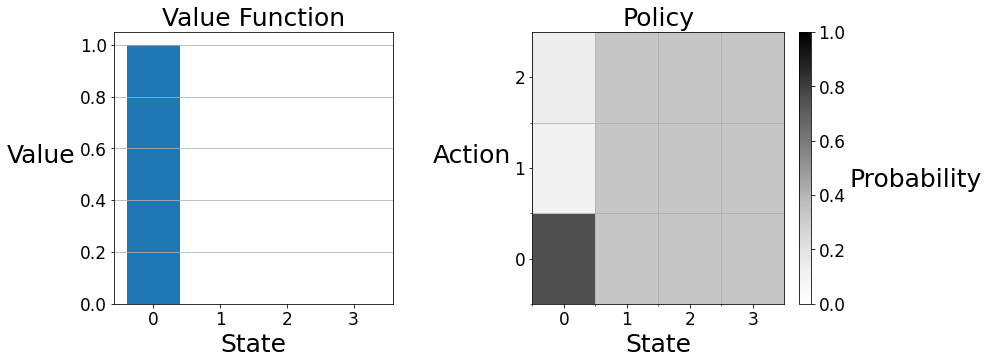

In [3]:
pi[0] = [0.75, 0.11, 0.14]                                # update pi in row 0 to probability of [0.75, 0.11, 0.14]                  

for s, pi_s in enumerate(pi):
    
    for a, p in enumerate(pi_s):
        
        print(f'pi(A={a}|S={s}) = {p.round(2)}    ', end='')
        
    print()
    
V[0] = 1

tools.plot(V, pi)

We can visualize a value function and policy with the `plot` function in the `tools` module. 

On the left, the value function is displayed as a barplot. ***State zero has an expected return of ten***, while the ***other states have an expected return of zero***. 

On the right, the policy is displayed on a two-dimensional grid. Each ***vertical strip gives the policy at the labeled state***. 
- In ***state zero, action zero is the darkest*** because the ***agent's policy makes this choice with the highest probability***. 
- In the ***other states*** the ***agent has the equiprobable policy***, so the vertical strips are colored uniformly.

In [4]:
# We can access the state space and the action set as attributes of the environment

print('State Space :', env.S)
print('')
print('Action Set :', env.A)

State Space : [0, 1, 2, 3]

Action Set : [0, 1, 2]


We will need to use ***the environment's `transitions` method*** to complete this assignment. 

The method ***takes a state and an action*** and ***returns a 2-dimensional array***:
- the entry at $(i, 0)$ is the reward for transitioning to state $i$ from the current state
- the entry at $(i, 1)$ is the conditional probability of transitioning to state $i$ given the current state and action.

In [5]:
state = 3
action = 1
transitions = env.transitions(state, action)
transitions

array([[1.        , 0.12390437],
       [2.        , 0.15133714],
       [3.        , 0.1848436 ],
       [2.        , 0.53991488]])

In [6]:
for sp, (r, p) in enumerate(transitions):
    
    print(f'p(S\'={sp}, R={r} | S={state}, A={action}) = {p.round(2)}')

p(S'=0, R=1.0 | S=3, A=1) = 0.12
p(S'=1, R=2.0 | S=3, A=1) = 0.15
p(S'=2, R=3.0 | S=3, A=1) = 0.18
p(S'=3, R=2.0 | S=3, A=1) = 0.54


# 1. Policy Evaluation

We're now ready to begin the assignment! 

First, the city council would like to evaluate the quality of the existing pricing scheme. 

### Policy evaluation works by iteratively applying the Bellman equation for $v_{\pi}$ to a working value function, as an update rule, as shown below.

$$\large v(s) \leftarrow \sum_a \pi(a | s) \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$
This update can either occur "in-place" (i.e. the update rule is sequentially applied to each state) or with "two-arrays" (i.e. the update rule is simultaneously applied to each state). Both versions converge to $v_{\pi}$ but the in-place version usually converges faster. 

**In this assignment, we will be implementing all update rules in-place**, as is done in the pseudocode of chapter 4 of the textbook. 

In [7]:
# Create Evaluate Policy function
def evaluate_policy(env, V, pi, gamma, theta):
    
    delta = float('inf')                                # initialize delta = infinity
    
    while delta > theta:                                
        
        delta = 0                                       # update delta = 0
        
        for state in env.S:                             # env.S: [0, 1, 2, 3]
            
            v = V[state]
            
            bellman_update(env, V, pi, state, gamma)    # apply bellman_update function
            
            delta = max(delta, abs(v - V[state]))
            
    return V

In [8]:
# Create Bellman Update function
def bellman_update(env, V, pi, state, gamma):
    
    newV = 0
    
    # loop over all actions
    for action in env.A:
        
        transitions = env.transitions(state, action)
        
        G = np.zeros(len(env.A))
        
        for newState in range(len(env.S)):
            
            pNewStateAfterAction = transitions[newState, 1]
            
            rewardNewStateAfterAction = transitions[newState, 0]
            
            G[action] += pNewStateAfterAction * (rewardNewStateAfterAction + gamma * V[newState])
            
        newV += pi[state, action] * G[action]
        
    V[state] = newV

In [9]:
# set up test environment
num_spaces = 10
num_prices = 4
env = tools.ParkingWorld(num_spaces, num_prices)

# build test policy
city_policy = np.zeros((num_spaces + 1, num_prices))
city_policy[:, 1] = 1

gamma = 0.9
theta = 0.1

V = np.zeros(num_spaces + 1)
V = evaluate_policy(env, V, city_policy, gamma, theta)

print(V)

[80.04173399 81.65532303 83.37394007 85.12975566 86.87174913 88.55589131
 90.14020422 91.58180605 92.81929841 93.78915889 87.77792991]


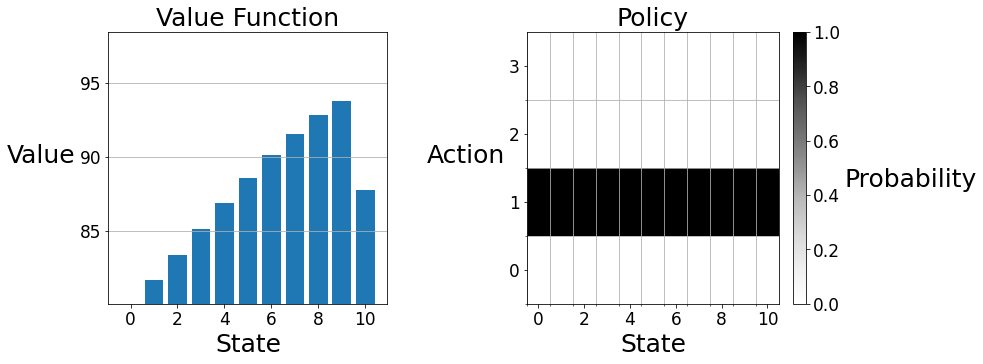

In [10]:
# use the ``plot`` function to visualize the final value function and policy.
tools.plot(V, city_policy)

Observe that the value function qualitatively resembles the city council's preferences &mdash; it monotonically increases as more parking is used, until there is no parking left, in which case the value is lower. 

Because of the relatively simple reward function:
- more reward is accrued when many but not all parking spots are taken
- less reward is accrued when few or all parking spots are taken
- the highly stochastic dynamics function (each state has positive probability of being reached each time step) the value functions of most policies will qualitatively resemble this graph. 

However, depending on the intelligence of the policy, the scale of the graph will differ. 

In other words, ***better policies will increase the expected return at every state rather than changing the relative desirability of the states***. 

Intuitively, the value of a less desirable state can be increased by making it less likely to remain in a less desirable state. 

Similarly, the value of a more desirable state can be increased by making it more likely to remain in a more desirable state. 

That is to say, ***good policies are policies that spend more time in desirable states and less time in undesirable states***. 

As we will see in this assignment, such a steady state distribution is achieved by setting the price to be low in low occupancy states (so that the occupancy will increase) and setting the price high when occupancy is high (so that full occupancy will be avoided).

# 2. Policy Iteration

Now the city council would like to compute a more efficient policy using policy iteration. 

***Policy iteration works by alternating between evaluating the existing policy and making the policy greedy with respect to the existing value function.*** 

We have written an outline of the policy iteration algorithm described in chapter 4.3 of the textbook. We will make use of the policy evaluation algorithm completed in section 1. and modifies the policy at $s$ to be greedy with respect to the q-values at $s$, to complete the policy improvement algorithm.

In [11]:
def improve_policy(env, V, pi, gamma):
    
    policy_stable = True
    
    for state in env.S:
        
        old = pi[state].copy()
        
        q_greedify_policy(env, V, pi, state, gamma)
        
        if not np.array_equal(pi[state], old):
            
            policy_stable = False
            
    return pi, policy_stable

def policy_iteration(env, gamma, theta):
    
    V = np.zeros(len(env.S))
    
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    
    policy_stable = False
    
    while not policy_stable:
        
        V = evaluate_policy(env, V, pi, gamma, theta)
        
        pi, policy_stable = improve_policy(env, V, pi, gamma)
        
    return V, pi

In [12]:
def q_greedify_policy(env, V, pi, state, gamma):
    
    G = np.zeros(len(env.A))
    
    # loop over all actions
    for action in range(len(env.A)):
        
        transitions = env.transitions(state, action)
        
        for newState in range(len(env.S)):
            
            pNewStateAfterAction = transitions[newState, 1]
            rewardNewStateAfterAction = transitions[newState, 0]
            G[action] += pNewStateAfterAction * (rewardNewStateAfterAction + gamma*V[newState])
            
    # set all action values to 0 for this state
    pi[state, :] = 0
    
    # For the action with max G, set the action value to 1
    pi[state, np.argmax(G)] = 1

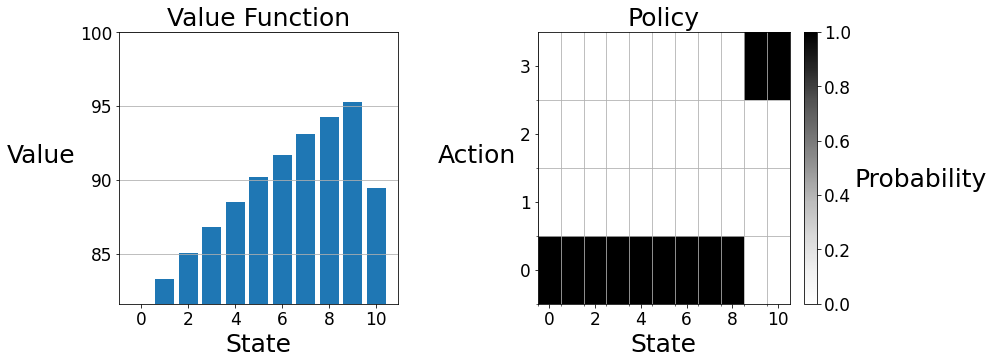

In [13]:
# test the policy iteration algorithm
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)

# use the plot function to visualize the final value function and policy.
tools.plot(V, pi)

We can check the value function (rounded to one decimal place) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        81.6 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        83.3 $\quad\quad\;$ 0<br>
2 $\quad\quad\quad\;$        85.0 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        86.8 $\quad\quad\;$ 0<br>
4 $\quad\quad\quad\;$        88.5 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        90.2 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        91.7 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        93.1 $\quad\quad\;$ 0<br>
8 $\quad\quad\quad\;$        94.3 $\quad\quad\;$ 0<br>
9 $\quad\quad\quad\;$        95.3 $\quad\quad\;$ 3<br>
10 $\quad\quad\;\;\,\,$      89.5 $\quad\quad\;$ 3<br>

# 3. Value Iteration
The city has also heard about value iteration and would like to implement it. 

***Value iteration works by iteratively applying the Bellman optimality equation for $v_{\ast}$ to a working value function***, as an update rule, as shown below.

$$\large v(s) \leftarrow \max_a \sum_{s', r} p(s', r | s, a)[r + \gamma v(s')]$$

In [14]:
def value_iteration(env, gamma, theta):
    
    V = np.zeros(len(env.S))
    
    while True:
        
        delta = 0
        
        for state in env.S:
            
            v = V[state]
            
            bellman_optimality_update(env, V, state, gamma)
            
            delta = max(delta, abs(v - V[state]))
            
        if delta < theta:
            
            break
            
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    
    for state in env.S:
        
        q_greedify_policy(env, V, pi, state, gamma)
        
    return V, pi

In [15]:
def bellman_optimality_update(env, V, state, gamma):
    
    actions = env.A
    
    q = np.zeros(len(env.A))
    
    for action in actions:
        
        transition = env.transitions(state, action)
        
        state_value_sum = 0
        
        for sprime, (reward, p) in enumerate(transition):
            
            state_value_sum += (p * (reward + gamma * V[sprime]))
        
        q[action] = state_value_sum
    
    V[state] = np.max(q)

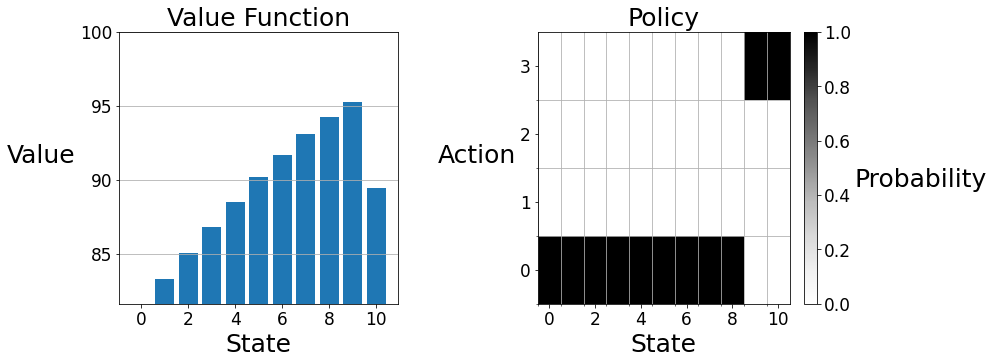

In [16]:
env = tools.ParkingWorld(num_spaces = 10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration(env, gamma, theta)

# use the plot function to visualize the final value function and policy.
tools.plot(V, pi)

We can check our value function (rounded to one decimal place) and policy against the answer below:<br>
State $\quad\quad$    Value $\quad\quad$ Action<br>
0 $\quad\quad\quad\;$        81.6 $\quad\quad\;$ 0<br>
1 $\quad\quad\quad\;$        83.3 $\quad\quad\;$ 0<br>
2 $\quad\quad\quad\;$        85.0 $\quad\quad\;$ 0<br>
3 $\quad\quad\quad\;$        86.8 $\quad\quad\;$ 0<br>
4 $\quad\quad\quad\;$        88.5 $\quad\quad\;$ 0<br>
5 $\quad\quad\quad\;$        90.2 $\quad\quad\;$ 0<br>
6 $\quad\quad\quad\;$        91.7 $\quad\quad\;$ 0<br>
7 $\quad\quad\quad\;$        93.1 $\quad\quad\;$ 0<br>
8 $\quad\quad\quad\;$        94.3 $\quad\quad\;$ 0<br>
9 $\quad\quad\quad\;$        95.3 $\quad\quad\;$ 3<br>
10 $\quad\quad\;\;\,\,$      89.5 $\quad\quad\;$ 3<br>

In the value iteration algorithm above, a policy is not explicitly maintained until the value function has converged. 

Below, we have written an identically behaving value iteration algorithm that maintains an updated policy. 

***Writing value iteration in this form makes its relationship to policy iteration more evident.*** 

Policy iteration alternates between doing complete greedifications and complete evaluations. 

On the other hand, value iteration alternates between doing local greedifications and local evaluations. 

In [17]:
def value_iteration2(env, gamma, theta):
    
    V = np.zeros(len(env.S))
    
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    
    while True:
        
        delta = 0
        
        for s in env.S:
            
            v = V[s]
            
            q_greedify_policy(env, V, pi, s, gamma)
            
            bellman_update(env, V, pi, s, gamma)
            
            delta = max(delta, abs(v - V[s]))
            
        if delta < theta:
            
            break
            
    return V, pi

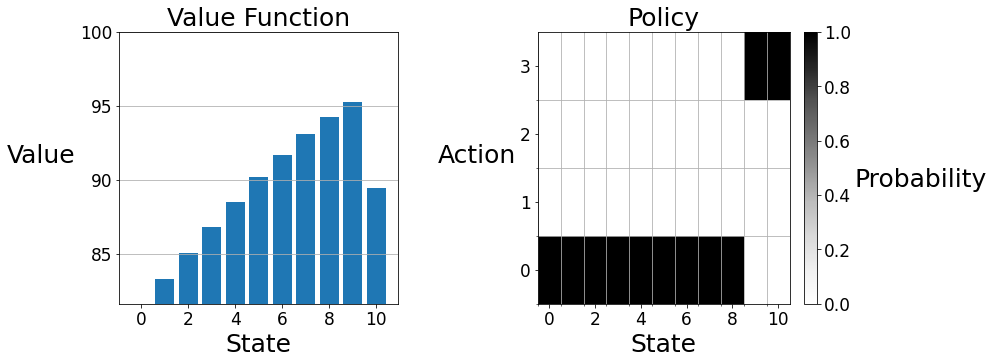

In [18]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration2(env, gamma, theta)
tools.plot(V, pi)

***End of Page***